## Lab 5: Logistic Regression - Solutions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# import various metrics for model scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

### Part 1. Insurance Claims Model

You have been asked to develop a model which would predict whether a health insurance policy holder will file a major insurance claim. The dataset "insurance2.csv" which you will use to train and evaluate your predictive model includes the following columns:

**Independent variables**

1. age : policyholder's age
2. sex: policyholder's gender (female=0, male=1)
3. bmi: Body mass index
4. children: number of children / dependents
5. smoker: smoking status (non-smoke=0;smoker=1) 
6. region: policyholder's reion of residence (northeast=0, northwest=1, southeast=2, southwest=3)
7. charges: insurance premium charges

**Target variable**

1. insuranceclaim - categorical variable (0 = no claims filed, 1 = at least one claim filed)

##### 1 - Import and explore the insurance data:

- read data into a pandas dataframe
- inspect the columns for data types and presence of missing data
- what is the number of unique values per each column?
- inspect the distribuion of the label column "insuranceclaim". Is this dataset balanced? 
- inspect the correlation coefficients between pairs of numerical columns. Are there particularly strong correlations (> 0.9)?

In [2]:
df = pd.read_csv('https://github.com/wsko/data_science_academy/raw/main/data/insurance2.csv')
print(df.head())

   age  sex     bmi  children  smoker  region      charges  insuranceclaim
0   19    0  27.900         0       1       3  16884.92400               1
1   18    1  33.770         1       0       2   1725.55230               1
2   28    1  33.000         3       0       2   4449.46200               0
3   33    1  22.705         0       0       1  21984.47061               0
4   32    1  28.880         0       0       1   3866.85520               1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [4]:
df.nunique()

age                 47
sex                  2
bmi                548
children             6
smoker               2
region               4
charges           1337
insuranceclaim       2
dtype: int64

In [5]:
df.insuranceclaim.value_counts()
## the data is balanced

1    783
0    555
Name: insuranceclaim, dtype: int64

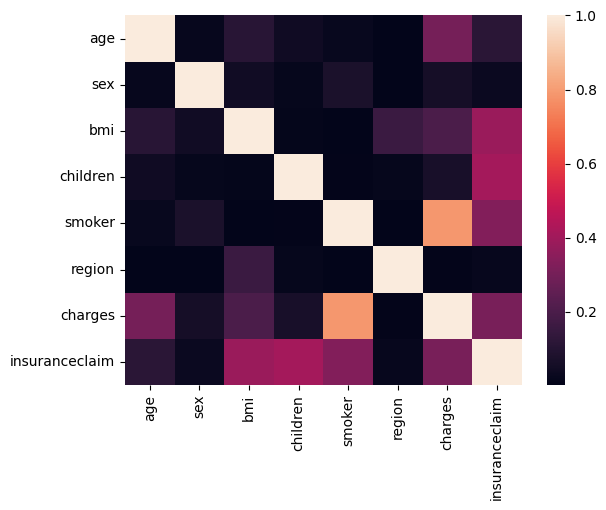

In [6]:
sns.heatmap(abs(df.corr()))
plt.show()

##### 2 - Prepare data for modeling

- Create a feature array X and label array y
- Split the data into a training and test set
- Perform data scaling using the min-max scaling algorithm

In [7]:
X = df.iloc[:, :-1].values
features = df.columns[:-1]
y = df.iloc[:, -1].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [9]:
#min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### 3 - Train and evaluate a predictive model


- Train a logistic regression model 
- Obtain the confusion matrix and classification report on the test set. What can you say about your model's performance?
- From model coefficients, how would you rank the variables in terms of their importance?

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
print(classification_report(y_test, lr.predict(X_test), target_names = ['Not filed', 'Filed'])[:220])
pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)), index = ['Not filed', 'Filed'], 
             columns = ["Not filed predicted","Filed predicted"])

              precision    recall  f1-score   support

   Not filed       0.83      0.84      0.84       161
       Filed       0.90      0.89      0.89       241

    accuracy                           0.87       402
  


,Not filed predicted,Filed predicted
Not filed,136,25
Filed,27,214


<AxesSubplot:xlabel='Features', ylabel='importance'>

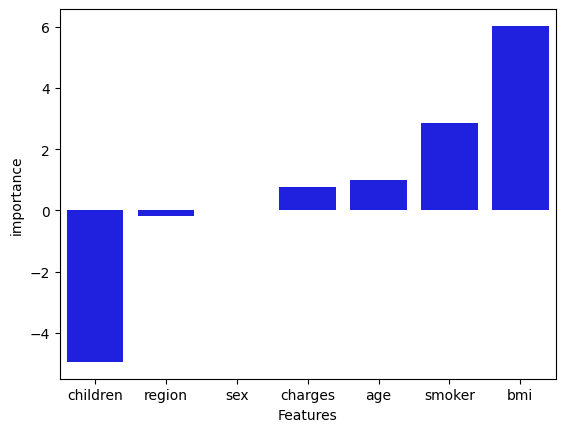

In [12]:
coeff = list(lr.coef_[0])
interp = pd.DataFrame()
interp['Features'] = features
interp['importance'] = coeff
interp.sort_values(by=['importance'], ascending=True, inplace=True)
sns.barplot(data = interp, x = "Features", y = 'importance', color = 'blue')

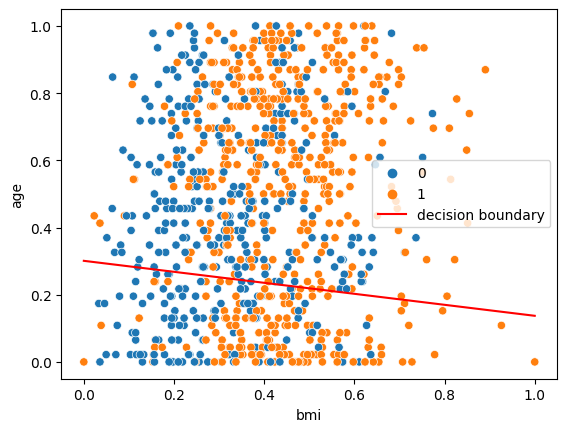

In [13]:
## decision boundary?
xx = np.array([0, 1])
yy = -(xx * lr.coef_[0][0] + lr.intercept_) / lr.coef_[0][2]
df_scaled = pd.DataFrame(X_train, columns=features)
df_scaled["insuranceclaim"] = y_train
ax = sns.scatterplot(x="bmi", y="age", hue="insuranceclaim", data=df_scaled)
ax = sns.lineplot(x=xx, y=yy, color="red", label="decision boundary")

### Part 2. Bank customer churn

Help a bank predict which customers are more likely to quit. The dataset provided for training a classifier model contains the following columns:

**Features**

- __CustomerId:__	A unique customer identification number
- __Surname:__	Customer’s last name
- __CreditScore:__	Customer’s credit score
- __Geography:__	Customer’s country
- __Gender:__	Customer’s gender
- __Age:__	Customer’s age
- __Tenure:__	Number of years that the customer has been a client of the bank
- __Balance:__	Customer’s account balance
- __NumOfProducts:__	Number of products the customer has purchased through the bank
- __HasCrCard:__	Whether or not a customer has a credit card
- __IsActiveMember:__	Is the customer active?
- __EstimatedSalary:__	Customer’s salary estimated from the customer’s bank product usage patterns

**Labels**

- __Exited:__	Whether or not the customer has left the bank


**Tasks:**

1. Import and inspect data
2. Prepare data for modeling:
    - Remove high-cardinality columns (hint: look for columns where the number of unique values is close to the number of rows in the dataset)
    - split the data into a training and test set
    - encode categorical variables
    - scale the feature columns
3. Train and evaluate a logistic regression model
4. Can you imprtove model performance (precision and recall) for each of the label classes (stay, exit) by adjusting the prediction threshold?


In [14]:
df = pd.read_csv("https://github.com/wsko/data_science_academy/raw/main/data/Churn_Modeling.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [15]:
# remove the first two columns

df = df.iloc[:, 2:]

In [16]:
# encode the categorical columns

df = pd.get_dummies(data = df, drop_first = True)

In [17]:
# examine label distribution

df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [18]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [19]:
X = df.drop(columns = ["Exited"]).values
y = df["Exited"].values
features = list(df.drop(columns = ["Exited"]).columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

#min max scaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, tol = 0.000001)
lr.fit(X_train, y_train)

lr.coef_

array([[-0.38010919,  5.01484046, -0.21048127,  0.67289818, -0.23073873,
        -0.06547864, -1.02391871,  0.01480004,  0.76815298,  0.08646951,
        -0.52821918]])

In [20]:
y_train_p = lr.predict(X_train)
y_test_p = lr.predict(X_test)

In [21]:
print(classification_report(y_train, y_train_p, target_names = ['Stay', 'Exit'])[:220])
pd.DataFrame(confusion_matrix(y_train, y_train_p), index = ["Stay", "Exit"], 
             columns = ["Stay predicted","Exit predicted"])

              precision    recall  f1-score   support

        Stay       0.82      0.97      0.89      5547
        Exit       0.63      0.21      0.32      1453

    accuracy                           0.81      7000
  


,Stay predicted,Exit predicted
Stay,5367,180
Exit,1147,306


In [22]:
print(classification_report(y_test, y_test_p, target_names = ['Stay', 'Exit'])[:220])
pd.DataFrame(confusion_matrix(y_test, y_test_p), index = ["Stay", "Exit"], 
             columns = ["Stay predicted","Exit predicted"])

              precision    recall  f1-score   support

        Stay       0.83      0.96      0.89      2416
        Exit       0.56      0.19      0.29       584

    accuracy                           0.81      3000
  


,Stay predicted,Exit predicted
Stay,2328,88
Exit,472,112


In [23]:
## to inspect the effects of the threshold, you will need raw sigmoid values from lr.predict_proba()

threshold = 0.1  ## try different vaues between 0 and 1

y_test_p = (lr.predict_proba(X_test)[:,1] > threshold).astype('int')

print(classification_report(y_test, y_test_p, target_names = ['Stay', 'Exit'])[:220])
pd.DataFrame(confusion_matrix(y_test, y_test_p), index = ["Stay", "Exit"], 
             columns = ["Stay predicted","Exit predicted"])

              precision    recall  f1-score   support

        Stay       0.95      0.34      0.50      2416
        Exit       0.25      0.93      0.40       584

    accuracy                           0.46      3000
  


,Stay predicted,Exit predicted
Stay,825,1591
Exit,41,543
